In [10]:
import os,sys
import csv
import copy
import math
import collections

import matplotlib
import matplotlib.pyplot as plt
import clawpack.petclaw as pyclaw
from clawpack import riemann
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans

from models.shallow_water_solver import shallow_solver
from schemes.avalanche_scheme import *

from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex

sys.path.append("/pymorph")
from schemes.weno import get_left_flux,get_right_flux
from schemes.weno import get_stencil
import sediment_transport.sed_trans as sedtrans


%matplotlib inline
%load_ext autoreload
%autoreload 2

#plt.style.use(['dark_background'])
#plt.style.use('presentation')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
filepath = '../Paper_3/flume_profile_smoothed_v002.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


In [12]:
def get_bathymetry(filepath, resolution=1):
    retval = collections.OrderedDict()
    z = []
    with open(filepath) as f:
        for line in f:
            values = line.split()
            if is_number(values[0])==False:
                if float(values[1]).is_integer():
                    retval[values[0]]=int(values[1])
                else:
                    retval[values[0]]=float(values[1])
            else:
                z.append(float(values[0]))
    z = np.array(z)
    print('Z: {0}'.format(len(z)))
    xmax = float(retval['nrows']) * retval['cellsize']
    nx = retval['nrows']
    dx = retval['cellsize']
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    x = np.linspace(0, nx*dx, num=len(z))
    f = interp1d(x, z)
    xnew = np.linspace(0, nx*dx, num=len(z)*resolution)
    znew = f(xnew)
    nx = len(xnew)

    return znew,xnew


def source_mannings(solver,state,dt):
    """
    Take a look at the paper on Hudson et al. 2005 regarding treatment of the source. 
    
    Note that I did run it for calm or quiesent conditions (i.e. u=0 for all t) and everything seemed okay.
           | 0 |
    S(Q) = |   |
           |gh(Slope-Sf)|
    """
    #Eventually the slope should be calculate from the actual bed.
    # Slope = 1.0/792.0
    q = state.q
    #grid = state.grid
    #xc=grid.x.centers 
    # Get the flow depth
    # Now adjust the momentum term
    n = 0.025
    Slope = 1.26/1000.
    
    Sf = (n**2)*q[1,:]*np.abs(q[1,:])/(q[0,:]**(10./3.))
    #q[1,:] = q[1,:] + q[0,:]* state.problem_data['grav'] * (Slope-Sf) *dt
    #print(Slope_bed.mean(), Slope)
    q[1,:] = q[1,:] + q[0,:]* state.problem_data['grav'] * (Slope-Sf) *dt


In [13]:
def run_model2(domain, zbathy, sea_level, kernel_language='Fortran', solver_type='classic', use_petsc=False):

    if use_petsc:
        import clawpack.petclaw as pyclaw
    else:
        from clawpack import pyclaw

    if kernel_language == 'Fortran':
        solver = pyclaw.ClawSolver1D(riemann.shallow_bathymetry_fwave_1D)
    elif kernel_language == 'Python':
        solver = pyclaw.ClawSolver1D(riemann.shallow_1D_py.shallow_fwave_1d)
        solver.kernel_language = 'Python'
    solver.limiters = pyclaw.limiters.tvd.vanleer
    solver.fwave = True
    solver.num_waves = 2
    solver.num_eqn = 2
    solver.step_source = source_mannings
    
    #print(pyclaw.steps_max)
    
    solver.bc_lower[0] = pyclaw.BC.periodic
    solver.bc_upper[0] = pyclaw.BC.periodic
    solver.aux_bc_lower[0] = pyclaw.BC.periodic
    solver.aux_bc_upper[0] = pyclaw.BC.periodic
    solver.max_steps = 100000

    state = pyclaw.State(domain, 2, 1)
    xc = state.grid.x.centers
    dx = state.grid.delta[0]
    print('Grid dx = {0}'.format(dx))
    print('Grid nx = {0}'.format(len(xc)))
    state = pyclaw.State(domain, 2, 1)

    # Gravitational constant
    state.problem_data['grav'] = 9.8
    state.problem_data['dry_tolerance'] = 1e-3
    state.problem_data['sea_level'] = 0.0

    xc = state.grid.x.centers
    state.aux[0, :] = zbathy
    # This is a flat surface
    state.q[0, :] = sea_level - state.aux[0, :]
    # Set the intial flow to 0.0 m/s
    state.q[1, :] = 0.02

    claw = pyclaw.Controller()
    claw.keep_copy = True
    claw.tfinal = 200
    claw.solution = pyclaw.Solution(state, domain)
    claw.solver = solver
    claw.write_aux_init = True
    
    status = claw.run()
    
    depth = claw.frames[claw.num_output_times].q[0,:]
    velocity = claw.frames[claw.num_output_times].q[1,:]/depth
    surface = depth +  state.aux[0, :]
    
    return velocity, surface, depth, xc, status



Z: 87
Z: 87
Grid dx = 0.06069767441860465
Grid nx = 43
2019-04-12 14:46:28,702 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-12 14:46:28,828 INFO CLAW: Solution 1 computed for time t=20.000000


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


2019-04-12 14:46:28,987 INFO CLAW: Solution 2 computed for time t=40.000000
2019-04-12 14:46:29,097 INFO CLAW: Solution 3 computed for time t=60.000000
2019-04-12 14:46:29,217 INFO CLAW: Solution 4 computed for time t=80.000000
2019-04-12 14:46:29,326 INFO CLAW: Solution 5 computed for time t=100.000000
2019-04-12 14:46:29,453 INFO CLAW: Solution 6 computed for time t=120.000000
2019-04-12 14:46:29,599 INFO CLAW: Solution 7 computed for time t=140.000000
2019-04-12 14:46:29,705 INFO CLAW: Solution 8 computed for time t=160.000000
2019-04-12 14:46:29,846 INFO CLAW: Solution 9 computed for time t=180.000000
2019-04-12 14:46:29,960 INFO CLAW: Solution 10 computed for time t=200.000000
{'cflmax': 0.9011028792010194, 'dtmin': 0.03223556926055295, 'dtmax': 0.036619130394362154, 'numsteps': 6143}
0.5 0.37823405298707363
Z: 87
Grid dx = 0.03
Grid nx = 87
2019-04-12 14:46:29,990 INFO CLAW: Solution 0 computed for time t=0.000000


/usr/local/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


2019-04-12 14:46:30,200 INFO CLAW: Solution 1 computed for time t=20.000000
2019-04-12 14:46:30,442 INFO CLAW: Solution 2 computed for time t=40.000000
2019-04-12 14:46:30,665 INFO CLAW: Solution 3 computed for time t=60.000000
2019-04-12 14:46:30,893 INFO CLAW: Solution 4 computed for time t=80.000000
2019-04-12 14:46:31,116 INFO CLAW: Solution 5 computed for time t=100.000000
2019-04-12 14:46:31,361 INFO CLAW: Solution 6 computed for time t=120.000000
2019-04-12 14:46:31,606 INFO CLAW: Solution 7 computed for time t=140.000000
2019-04-12 14:46:31,829 INFO CLAW: Solution 8 computed for time t=160.000000
2019-04-12 14:46:32,081 INFO CLAW: Solution 9 computed for time t=180.000000
2019-04-12 14:46:32,302 INFO CLAW: Solution 10 computed for time t=200.000000
{'cflmax': 0.9005923089940836, 'dtmin': 0.01587972657162507, 'dtmax': 0.018079659675863658, 'numsteps': 12458}
1 0.3846083109405117
Z: 87
Grid dx = 0.015
Grid nx = 174
2019-04-12 14:46:32,317 INFO CLAW: Solution 0 computed for time t

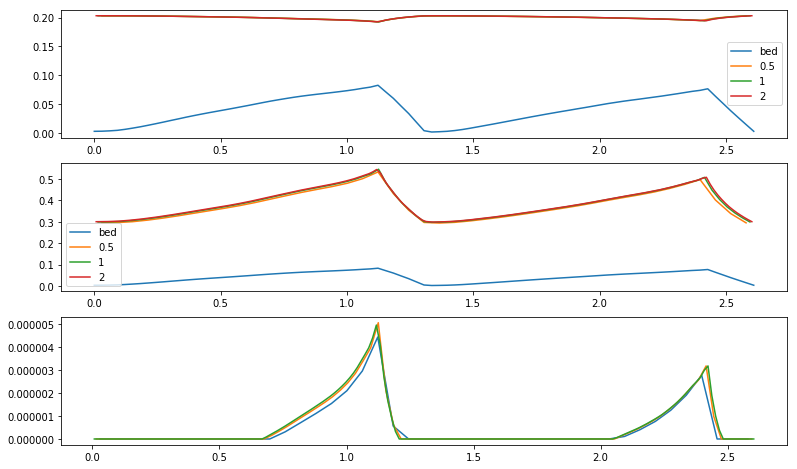

In [14]:
velocities = []   
depths = []
surfaces =[]

resolutions=[0.5, 1, 2]

plt.figure(figsize=(13,8))

ax1 = plt.subplot(311)
zbathy,xc = get_bathymetry(filepath, 1)
plt.plot(xc,zbathy,label='bed')

ax2 = plt.subplot(312)
plt.plot(xc,zbathy,label='bed')


for res in resolutions:
    
    bathy, xs = get_bathymetry(filepath, res)
    x = pyclaw.Dimension(0.0,xs.max(),len(xs),name='x')
    domain = pyclaw.Domain(x)
   
    
    velocity, surface, depth, xc, status =run_model2(domain, bathy, 0.2, kernel_language='Fortran', solver_type='classic', use_petsc=True)
    #velocity, surface, depth, xc = run_model(0.2, res,filepath)
    print(status)
    print(res, velocity.mean())
    
    ax1 = plt.subplot(311)
    plt.plot(xc,surface, label=res)
    
    ax2 = plt.subplot(312)
    plt.plot(xc,velocity, label=res)
    
    qbedload = np.zeros(len(xc))
    slope = np.zeros(len(xc))
    for i in range(0,len(xc)): #i=2 
        qbedload[i] = sedtrans.get_unit_bed_load_slope(depth[i],velocity[i],0.001,slope[i], 
                                                           2650., angleReposeDegrees = 30.0, 
                                                           type='bagnold',
                                                            useSlopeAdjust=False)
    ax3 = plt.subplot(313)
    plt.plot(xc,qbedload)

ax1 = plt.subplot(311)
plt.legend()
ax2 = plt.subplot(312)
plt.legend()

Z: 87
Z: 87
Grid dx = 0.03
Grid nx = 87
2019-04-12 14:52:41,575 INFO CLAW: Solution 0 computed for time t=0.000000
2019-04-12 14:52:41,797 INFO CLAW: Solution 1 computed for time t=20.000000
2019-04-12 14:52:42,023 INFO CLAW: Solution 2 computed for time t=40.000000
2019-04-12 14:52:42,253 INFO CLAW: Solution 3 computed for time t=60.000000
2019-04-12 14:52:42,535 INFO CLAW: Solution 4 computed for time t=80.000000
2019-04-12 14:52:42,890 INFO CLAW: Solution 5 computed for time t=100.000000
2019-04-12 14:52:43,174 INFO CLAW: Solution 6 computed for time t=120.000000
2019-04-12 14:52:43,440 INFO CLAW: Solution 7 computed for time t=140.000000
2019-04-12 14:52:43,679 INFO CLAW: Solution 8 computed for time t=160.000000
2019-04-12 14:52:43,912 INFO CLAW: Solution 9 computed for time t=180.000000
2019-04-12 14:52:44,137 INFO CLAW: Solution 10 computed for time t=200.000000
{'cflmax': 0.9005923089940836, 'dtmin': 0.01587972657162507, 'dtmax': 0.018079659675863658, 'numsteps': 12458}
2 0.384

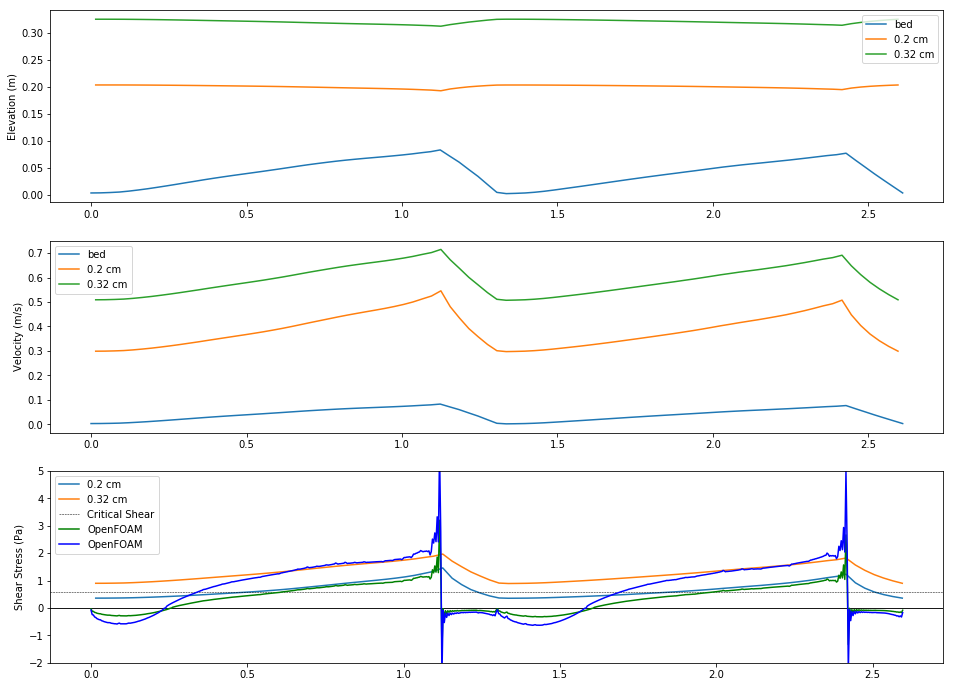

In [29]:
velocities = []   
depths = []
surfaces =[]


taufilepath = r'/data/PhD/LRN-WallTreatments-openFOAM-5.x/validation/QueensFlume/32.cm/dune.127z.30r.colebrook.yp.0.x/30/wallShearStress.txt'
tau32df = pd.read_csv(taufilepath, sep='\t', index_col=0)

taufilepath = r'/data/PhD/LRN-WallTreatments-openFOAM-5.x/validation/QueensFlume/20.cm/dune.100z.30r.colebrook.yp.0.x/30/wallShearStress.txt'
tau20df = pd.read_csv(taufilepath, sep='\t', index_col=0)



levels=[00.2,0.32]

plt.figure(figsize=(16,12))

ax1 = plt.subplot(311)
zbathy,xc = get_bathymetry(filepath, 1)
plt.plot(xc,zbathy,label='bed')

ax2 = plt.subplot(312)
plt.plot(xc,zbathy,label='bed')


for level in levels:
    
    bathy, xs = get_bathymetry(filepath, 1)
    x = pyclaw.Dimension(0.0,xs.max(),len(xs),name='x')
    domain = pyclaw.Domain(x)
   
    
    velocity, surface, depth, xc, status =run_model2(domain, bathy, level, kernel_language='Fortran', solver_type='classic', use_petsc=True)
    #velocity, surface, depth, xc = run_model(0.2, res,filepath)
    print(status)
    print(res, velocity.mean())
    
    label = '{0} cm'.format(level)
    
    ax1 = plt.subplot(311)
    plt.plot(xc,surface, label=label)
    
    ax2 = plt.subplot(312)
    plt.plot(xc,velocity, label=label)
    
    qbedload = np.zeros(len(xc))
    slope = np.zeros(len(xc))
    tau = np.zeros(len(xc))
    for i in range(0,len(xc)): #i=2 
        tau[i] = sedtrans.get_bed_shear(depth[i],velocity[i], 0.002)
        qbedload[i] = sedtrans.get_unit_bed_load_slope(depth[i],velocity[i],0.001,slope[i], 
                                                           2650., angleReposeDegrees = 30.0, 
                                                           type='bagnold',
                                                            useSlopeAdjust=False)
    ax3 = plt.subplot(313)
    plt.plot(xc,tau,label=label)
    
    

ax1 = plt.subplot(311)
plt.legend()
plt.ylabel('Elevation (m)')
ax2 = plt.subplot(312)
plt.ylabel('Velocity (m/s)')
plt.legend()

ax3 = plt.subplot(313)
plt.ylabel('Shear Stress (Pa)')
plt.axhline(y=0.6,color='k', linestyle='--',linewidth=0.5,label='Critical Shear')
plt.ylim([-2.0,5.])
plt.axhline(y=0,color='k', linestyle='-',linewidth=0.9,label='')

plt.plot(tau20df.index,tau20df.tau,'g-', label='OpenFOAM')

plt.plot(tau32df.index,tau32df.tau,'b-', label='OpenFOAM')
plt.legend()